# <center> PROJET DE MACHINE LEARNING FOR NLP </center>

<center> <img src = "Images/logo_ensae.png",
              width="400", 
              height="341"/><center>

#### <center>  Réalisé par : </center>


<center>ESSOH Lasme Ephrem Dominique (DSSA) </center>
<center>CHABAUD Mathieu (DSBD) </center>
<center>BERREBI Nathan (DSSA)</center>

<br>

<center>Elèves-Ingénieurs 3A (2021 - 2022)</center>




#### <center> Thème :  </center> 

# <center> Analyses textuelles sur Amazon Product Data : sentiment analysis and texts generation </center>


## Modules

In [1]:
#gestion des exceptions
import warnings
warnings.filterwarnings('ignore')

In [2]:
#gestion des répertoires
import os

#pour le chargement des données depuis notre espace S3 AWS
import boto3

#modules de base pour la science des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#gestion et preprocessing des données textuelles
import string
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer

#pour la réalisation des nuages de mots
from wordcloud import WordCloud, STOPWORDS

#pour l'entraînement réseau de neuronnes artificielles pour le sentiment analysis
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer #Tokenizer pour bert
from transformers import BertForSequenceClassification

#pour la séparation des données afin d'estimer l'erreur de généralisation
from sklearn.model_selection import train_test_split

#pour le calcul de la métrique utilisée pour évaluer le classifieur pour le sentiment analysis
from sklearn.metrics import f1_score

#pour la bar de progression
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lasme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Jeu de données

Pour plus d'information sur le jeu de données brut que nous utilisons, il faut consulter l'adresse web suivante : https://nijianmo.github.io/amazon/index.html

Le script qui suit récupère automatiquement les données depuis notre espace AWS S3, dans le cas où ils ne sont pas disponibles sur votre espace local, et les stocke ensuite. Dans le cas contraire, ce script se contente de juste charger les données en mémoire dans un objet pandas DataFrame nommé df.

In [3]:
url = "s3://nlpensae3a2022/Amazon_Digital_Music.csv" #url de stockage des données dans un espace s3

def fetch_data(dump_url = url):
    """cette fonction récupère automatiquement les données (si besoin)"""
    if not os.path.isdir("Raw"):
        os.makedirs("Raw")
        print("Chargement des données en cours, patientez encore ...")
        print("===============================================================")
        client = boto3.client("s3")
        df = pd.read_csv(dump_url)
        print("...")
        print("...")
        print("...")
        df.to_csv("Raw/Amazon_Digital_Music.csv", index=False)
        print("Chargement terminé !")
        return df
        
    else:
        return pd.read_csv("Raw/Amazon_Digital_Music.csv")

Récupération des données : 

In [4]:
df = fetch_data()

In [5]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

In [6]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"12 22, 2013",A1ZCPG3D3HGRSS,0001388703,{'Format:': ' Audio CD'},mark l. massey,This is a great cd full of worship favorites!!...,Great worship cd,1387670400,NaN,NaN
1,5.0,True,"09 11, 2013",AC2PL52NKPL29,0001388703,{'Format:': ' Audio CD'},Norma Mushen,"So creative! Love his music - the words, the ...",Gotta listen to this!,1378857600,NaN,NaN
2,5.0,True,"03 2, 2013",A1SUZXBDZSDQ3A,0001388703,{'Format:': ' Audio CD'},Herbert W. Shurley,"Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,1362182400,NaN,NaN
3,5.0,True,"12 2, 2012",A3A0W7FZXM0IZW,0001388703,{'Format:': ' Audio CD'},Mary M Raybell,Keith Green had his special comedy style of Ch...,Great A must have,1354406400,NaN,NaN
4,5.0,False,"01 7, 2012",A12R54MKO17TW0,0001388703,{'Format:': ' Audio CD'},J. Bynum,Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,1325894400,6.0,NaN


df.shapes

Dans ce travail, nous traitons de plus de 1 millions d'avis de consommateurs sur des produits de la categorie Digital Music achetée depuis le site de vente ligne Amazon. Il y a en tout 12 colonnes mesurant diverses informations sur ces avis, nous intéressons principale au commentaire refletant les avis des consommateurs ainsi que leur évaluation sur une échelle de 1 à 5 

Dans ce qui suit, nous présentons une prétraitement ainsi qu'une analyse exploratoire des données sur les 1,5 millions d'avis. Certains prétraitement peuvent mettre du temps à se finaliser à cause de la taille relativement importante du jeu de données.

## Preprocessing des données

Nous commençons par prétraités les colonnes ensuite nous nous attaquons aux données textuelles. 

* Traitement des colonnes :

Etant donné que les notes sont regroupées de 0 à 5, nous nous proposons de les regrouper en classe de trois : négatif, neutre et positif. On définit la fonction suivante :

In [7]:
def classify(x):
    if x == 5.0 or x == 4.0:
        return 2 #positif
    if x == 3.0:
        return 1 #neutre
    return 0 #négatif

df["y"] = df["overall"].apply(classify)

Supprimons ensuite les colonnes qui ne nous seront pas utiles : 

In [8]:
df = df.drop(labels = ["verified", "reviewerID", "asin" ,"style","reviewerName", "unixReviewTime","vote", "image"],axis = 1)
df.head()

,overall,reviewTime,reviewText,summary,y
0,5.0,"12 22, 2013",This is a great cd full of worship favorites!!...,Great worship cd,2
1,5.0,"09 11, 2013","So creative! Love his music - the words, the ...",Gotta listen to this!,2
2,5.0,"03 2, 2013","Keith Green, gone far to early in his carreer,...",Great approach still gets the message out,2
3,5.0,"12 2, 2012",Keith Green had his special comedy style of Ch...,Great A must have,2
4,5.0,"01 7, 2012",Keith Green / So you wanna go back to Egypt......,A great one from Keith with a guest appearance...,2


* Traitement des commentaires : 

Supprimons toutes les ponctuations  des textes décrivant les commentaires de produits "reviewText". Il s'agit des caractères suivants :  *!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~. Nous réalisons cette suppression avec la module string et son attribut ponctuation : string.ponctuation en définissant la fonction suivante :            

In [9]:
def remove_punctuation(text):
    no_punct = [words for words in text if words not in string.punctuation]
    words_wo_punct =''.join(no_punct)
    return words_wo_punct

df["reviewText"] = df["reviewText"].astype(str)
df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuation(x.lower()))

Procédons ensuite à d'autres traitements de textes : la racinisation des mots employés (pour rappel, c'est le processus qui consiste ramener un mot à sa racine. Nous utilisons ici la racinisation à algorithme de Porter), l'élimination des stopwords et la gestion des expressions régulières :

In [10]:
def text_process(df):
    # racinisation
    stemmer = PorterStemmer()
    # élimination des stop words anglais comme "the, I, our etc"
    words = stopwords.words("english") 
    df['cleaned_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
    print("Prétraitement des données en cours, patientez encore ...")
    print("===============================================================")
    print("...")
    print("...")
    print("...")
    df.to_csv("Raw/Amazon_Digital_Music_Cleaned.csv", index = False)
    print("Prétraitement terminé !")
    return df

df = text_process(df)

Prétraitement des données en cours, patientez encore ...
...
...
...
Prétraitement terminé !


In [11]:
df.head()

,overall,reviewTime,reviewText,summary,y,cleaned_reviews
0,5.0,"12 22, 2013",this is a great cd full of worship favorites ...,Great worship cd,2,great cd full worship favorit time great keith...
1,5.0,"09 11, 2013",so creative love his music the words the mes...,Gotta listen to this!,2,creativ love music word messag favorit song cd...
2,5.0,"03 2, 2013",keith green gone far to early in his carreer l...,Great approach still gets the message out,2,keith green gone far earli carreer left us gol...
3,5.0,"12 2, 2012",keith green had his special comedy style of ch...,Great A must have,2,keith green special comedi style chirstian mus...
4,5.0,"01 7, 2012",keith green so you wanna go back to egypt in...,A great one from Keith with a guest appearance...,2,keith green wanna go back egypt album keith ge...


## Analyse exploratoire des données

### Distributions des sentiments

In [12]:
#transformons d'abors les encodages numériques en étiquettes nominales
df["classes"] = df["overall"]
df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["classes"].unique()

# Supprimons aussi les lignes sans commentaires
df = df.dropna(subset=['cleaned_reviews'])

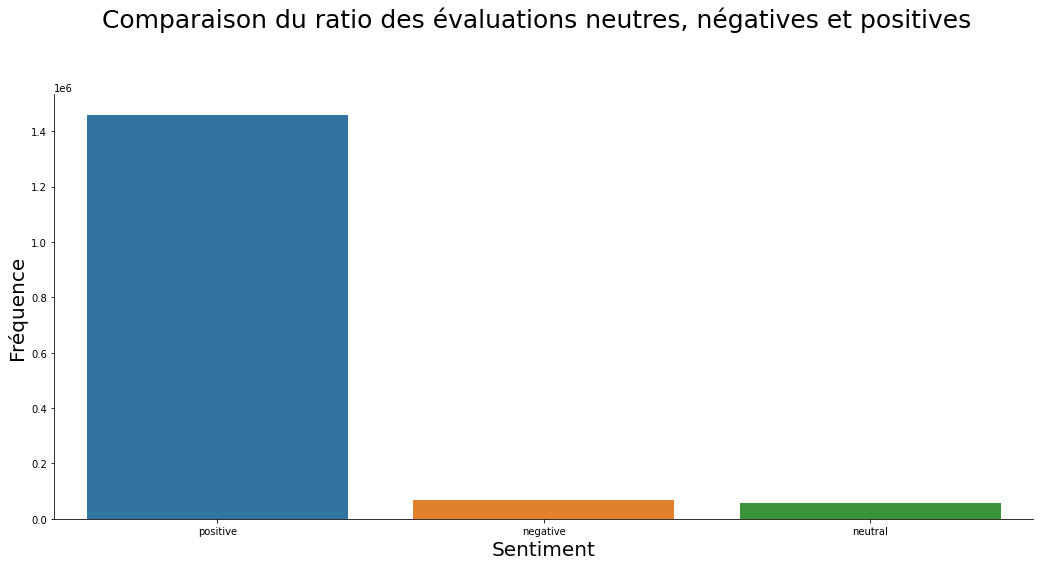

In [13]:
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparaison du ratio des évaluations neutres, négatives et positives", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Fréquence", fontsize = 20)
sns.despine()

Les évaluation sont majoritairements positives, le jeu de données est déséquilibré !

In [14]:
def pert_count(data, category):
    return (len(data[data["classes"] == category])/len(data)) * 100
print(f"Percentage de mots \"neutre\" --> {pert_count(df, 'neutral')} %")
print(f"Percentage de mots \"negatif\"  --> {pert_count(df, 'negative')} %")
print(f"Percentage de mots \"positif\" --> {pert_count(df, 'positive')} %")

Percentage de mots "neutre" --> 3.620204004590671 %
Percentage de mots "negatif"  --> 4.208052360925761 %
Percentage de mots "positif" --> 92.17174363448358 %


### Nuage de mots

Nous définissons la fonction ci-dessous pour réaliser un nuage des mots usuels :

In [15]:
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.25)
    plt.imshow(wordcloud)
    plt.show()

Réprésentons les nuages de mots les plus usuels en fonction des avis :

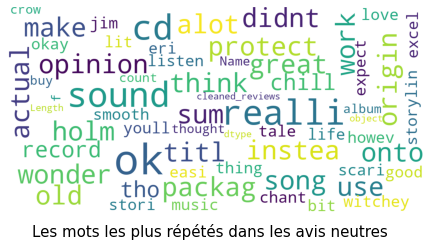

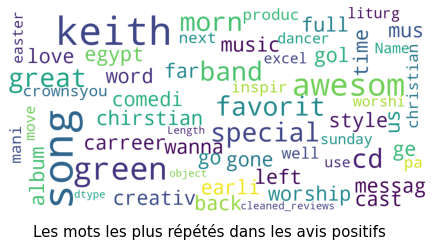

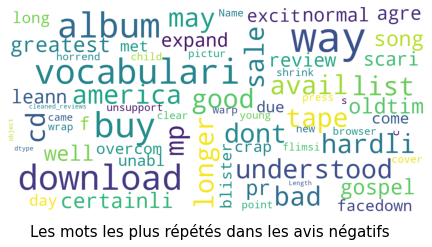

In [16]:
neu=df[df["classes"] == "neutral"]["cleaned_reviews"]
neg=df[df["classes"] == "negative"]["cleaned_reviews"]
pos=df[df["classes"] == "positive"]["cleaned_reviews"]
word_cloud(neu, "Les mots les plus répétés dans les avis neutres")
word_cloud(pos, "Les mots les plus répétés dans les avis positifs")
word_cloud(neg, "Les mots les plus répétés dans les avis négatifs")

### Expressions les plus fréquentes dans le jeu de données

Nous présentons des bigrammes en fonction des avis.

In [17]:
#création des bigrammes
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#tracés des bigrammes
def n_gram_plot(data,title,color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('Commentaire {} (Bigramme)'.format(title),fontsize=10)
    plt.yticks(rotation=0,fontsize=15)

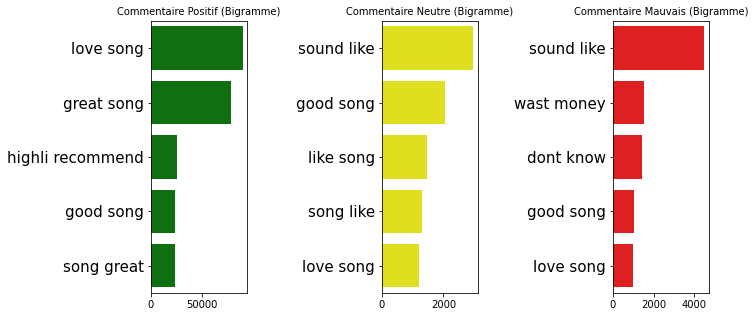

In [18]:
common_words_good = get_top_n_bigram(pos, 5)
common_words_neutral= get_top_n_bigram(neu, 5)
common_words_bad= get_top_n_bigram(neg, 5)

plt.figure(figsize=(10,5))

#top 5 bigrammes des avis positifs
plt.subplot(151)
n_gram_plot(common_words_good,'Positif','green')
#============================================= 
#top 5 bigrammes des avis neutres
plt.subplot(153)
n_gram_plot(common_words_neutral,'Neutre','yellow')
#============================================= 
#top 5 bigrammes des avis négatifs
plt.subplot(155)
n_gram_plot(common_words_bad,'Mauvais','red')
plt.show()

On peut voir que les commentaires postifs et négatifs sont très proches.

## Sentiment analysis

Dans cette section, nous menons une analyse de sentiment des avis des consommateurs.

In [19]:
df = df.sample(n=100000, weights='overall', random_state=1).reset_index(drop=True)

In [20]:
df.shape

(100000, 7)

In [21]:
df.head()

,overall,reviewTime,reviewText,summary,y,cleaned_reviews,classes
0,4.0,"01 24, 2008",im not a fan of all of crowders music but ther...,Fun song,2,im fan crowder music select one one especi enj...,positive
1,5.0,"05 12, 2018",beautiful mix of the song,Five Stars,2,beauti mix song,positive
2,5.0,"06 24, 2013",love dallas holm his songs are truly inspiring...,Love it! Fast service!! Thank U!!,2,love dalla holm song truli inspir cd great scr...,positive
3,4.0,"07 20, 2017",this is the roger waters cd weve all been wait...,Great production.,2,roger water cd weve wait pink floydish great p...,positive
4,5.0,"06 20, 2014",i wanted the original release of this song but...,Review:,2,want origin releas song accid bought live vers...,positive


In [22]:
df['y'].value_counts()

2    96371
1     2369
0     1260
Name: y, dtype: int64

In [23]:
# Creating a dictionary which contains all unique attributes in y, here these are the classes
possible_labels = df.y.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(possible_label)
label_dict

{2: 2, 1: 1, 0: 0}

In [24]:
# Changing column name from y to label for clarity
df['label'] = [label_dict[str_label] for str_label in df['y']]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.40, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

# creating a column data_type to denote whether each record is for test or train
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['y', 'label', 'data_type']).count()

overall  reviewTime  reviewText  summary  cleaned_reviews  \
y label data_type                                                              
0 0     train          756         756         756      755              756   
        val            504         504         504      503              504   
1 1     train         1421        1421        1421     1421             1421   
        val            948         948         948      948              948   
2 2     train        57823       57823       57823    57803            57823   
        val          38548       38548       38548    38527            38548   

                   classes  
y label data_type           
0 0     train          756  
        val            504  
1 1     train         1421  
        val            948  
2 2     train        57823  
        val          38548

In [26]:
# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)              
# Encoding training batch                           
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
# Encoding validation batch                           
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].reviewText.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

# Extracting variables from encoded objects for ease of use
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

# création des tenseurs
labels_val = torch.tensor(df[df.data_type=='val'].label.values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [27]:
# Initialisation du BERT pour la classification de séquences
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
batch_size = 1
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [29]:
# Importing the adam optimizer and a scheduler to manage learning rate in an optimal fashion
from transformers import AdamW, get_linear_schedule_with_warmup

# Initializing the optimizer (uses the adam algorithm - an extension to stochastic gradient descent)
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
# Définissions du nombre d'epochs
epochs = 3

# Scheduler to increase learning rate for a certain number of steps then linearly deacrese the same
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [30]:
#calcul de la f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

#calcul de l'accuracy par classe de notation (negatif, neutre, positif)
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct=0
    total=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        correct+=len(y_preds[y_preds==label])
        total+=len(y_true)
    print(f'Bert Model Accuracy Overall :',correct/total)

In [31]:
#verification de la présence d'un GPU. Sinon utilisation d'un CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu")
model.to(device)
print(device)

cuda


In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Fonction Evaluate utilisée avec tqdm pour afficher la progression en live de l'apprentissage du modèle
def evaluate(dataloader_val):

    # used to turn off layers that dont perform as expected
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  
#Entrainement du modèle
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
      
    # Ecriture des résultats  
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    #Sauvegarde du modèle finetuned par epoch
    #torch.save(model.state_dict(), f'/BERT{epoch}.model')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/60000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.20460614824433035
Validation loss: 0.17299924597630162
F1 Score (Weighted): 0.9597748131702805


Epoch 2:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
#Affichage des accuracy par classe de label
accuracy_per_class(predictions, true_vals)

## Texts Generation